09/2017 

A. Gentile

### learning via QLE from experimental data the parameters for the Childress "oscillators' bath" model


## Library uploading

In [1]:
# print inline matplotlib figs
%matplotlib inline 

RUN TWICE THE 2 LINES BELOW

In [17]:
run warmup_loading_Hahn.py  # import libraries 

Standard libraries imported
Neg weights warning filtered
Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results
Customised libraries imported


In [18]:
datadir=os.path.join("..","..","..","Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho01_highres")
SETTINGS.init('signal', datadir)

For this run I am using data in directory: 
..\..\..\Hamiltonian Learning With Seb\Decoherence_learning\NV05_HahnEcho01_highres


..\SETTINGS.py:67: UserWarning: Remember to set the correct parameters in the SETTINGS.PY
  warnings.warn("Remember to set the correct parameters in the SETTINGS.PY")


In [19]:
# used for log purposes
%run LoggingCode.py 

In [20]:
import HahnSimQMD as gsi # the model being used for simulations

In [21]:
run allmyfonts.py # settings for the printout

Fonts loaded


## Reload when needed

In [22]:
imp.reload(pros)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)
imp.reload(distr)
imp.reload(HTM)
imp.reload(SETTINGS)   #reload 2x if raises errors

<module 'SETTINGS' from '..\\SETTINGS.py'>

# Model "NewAnalytical" 

learning mean, delta, sigma with user-imposed megoffset & sigmaO // magoffset taken also from Gaussian distribution

## Data import

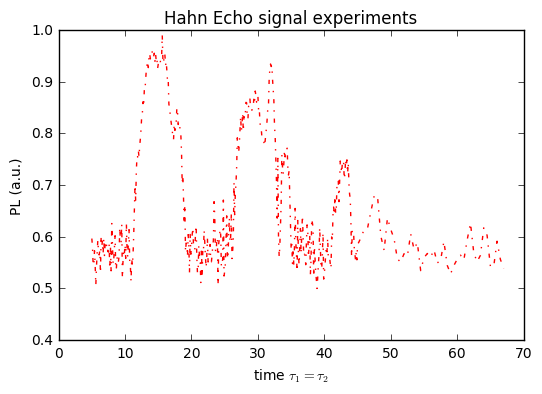

In [207]:
plt.plot(SETTINGS.sigdata[:,0], SETTINGS.sigdata[:,1], "r-.", label='raw-data')
plt.title('Hahn Echo signal experiments')

plt.xlabel(r'time $\tau_1 = \tau_2$')
plt.ylabel('PL (a.u.)')

plt.show()

In [260]:
print("Overall collected data amounts to: " + str(len(SETTINGS.sigdata[:,1])))

Overall collected data amounts to: 437


## Parameter and prior initialisation

In [333]:
"""Same initial guess as for the QLE simulated learning"""
 
true_params = np.array([[0.385, 5.7*10**-2, 17*10**-3]])
sigmas = np.array([0.2, 2*10**-2, 8*10**-3])
scramble = np.array([0.15, 1*10**-2, 4*10**-3])

In [46]:
boundaries = np.array([ [0,1], [0, 0.1], [0, 0.1]])# [0, 0.1], [0, 0.1]
np.all(true_params > boundaries[:,0], axis=1) and np.all(true_params < boundaries[:,1], axis=1)

array([ True], dtype=bool)

# Results from QLE trivial step-by-step implementation

In [153]:
# Prior obtained from parameters user-chosen

prior = distr.MultiVariateNormalDistributionNocov(len(true_params[0]), mean = true_params[0]+scramble, sigmas = sigmas)

In [154]:
prior.sample()

array([[ 0.47344093,  0.06823051,  0.0176881 ]])

run from __"Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho01_highres"___

In [155]:
invertize=False
source = 'offline'
model = gsi.HahnSignalAnaSimQMD(modelparams=true_params, Nqubit_interact = 20, bound_params = boundaries,  
                      IQLE=invertize, datasource = source)

n_particles = 100
n_experiments = 200

# higher resample_threshold -> higher frequency of resampling
# higher a in LiuWest -> less "data scrambling", slower learning
updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.53, resampler = qi.LiuWestResampler(a=0.84), debug_resampling=True)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, inv_field=inv_field)
experiment = heuristic()
print('Heuristic output:' + repr(experiment))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Inversion fields are: ['w_1', 'w_2', 'w_3']
Heuristic output:array([ (4.653899011072271, 0.5206177854867216, 0.12418769547920991, 0.020435399206671527)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8'), ('w_3', '<f8')])
Initialization Ready


"""Interestingly, it appears that for this case where the minimum outcome of the experiment is 0.5, the non-majority voted data could be a more robust implementation"""

experiment[0][0] = 25

datum = [model.simulate_experiment(true_params, experiment) for i in range(1000)]
print("Mean data: " + repr(np.mean(datum)))
print("Majo voting: " + repr(model.simulate_majo_experiment(true_params, experiment)  ))

#updater.update(datum, experiment)

In [156]:
start = time.clock()

# probecounter for the choice of the state
probecounter = 0


track_eval = np.empty([n_experiments,len(true_params[0])])
track_loss = np.empty(n_experiments)
track_cov = np.empty(n_experiments)
track_time = np.empty(n_experiments)

track_particle_locs = np.empty([n_particles, len(true_params[0]), n_experiments])
track_particle_wght = np.empty([n_particles, n_experiments])

resample_events = []

for idx_experiment in range(n_experiments):
    
    experiment = heuristic()
    experiment[0][0] = 1.27*experiment[0][0]
    print('Chosen experiment: ' + repr(experiment[0][0]))
    if source == 'offline':
        experiment[0][0] = (EXPfromVector(SETTINGS.sigdata, experiment[0][0]))[0]
        print('Found experiment: ' + repr(experiment[0][0]))
    
    if idx_experiment == 0:
        print('Initial time selected > ' + str(experiment[0][0]))
    if idx_experiment == n_experiments-1:
        print('Final time selected > ' + str(experiment[0][0]))
    
    track_time[idx_experiment] = experiment[0][0]
    
    datum = model.simulate_experiment(true_params, experiment)
    print('Extracted datum: ' + repr(datum))
    updater.update(datum, experiment)
    if updater._just_resampled == True:
        resample_events.append(idx_experiment)
    
#     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)

    track_cov[idx_experiment] = np.linalg.norm(updater.est_covariance_mtx())
    
    track_particle_locs[:, :, idx_experiment] = updater.particle_locations
    track_particle_wght[:, idx_experiment] = updater.particle_weights

    new_eval = updater.est_mean()
    track_eval[idx_experiment] = new_eval
    
    new_loss = eval_loss(model, new_eval, true_params)
    track_loss[idx_experiment] = new_loss[0]
    
end = time.clock()

print("\n\nElapsed time:" + str(end-start) + " secs")

Chosen experiment: 63.911462376920966
Found experiment: 64.0
Initial time selected > 64.0
Extracted datum: 1
Chosen experiment: 3.9478910316771572
Found experiment: 5.0
Extracted datum: 0
Chosen experiment: 3.638254671050027
Found experiment: 5.0
Extracted datum: 0
Chosen experiment: 14.992076088515153
Found experiment: 15.0
Extracted datum: 0
Chosen experiment: 4.1179926636939062
Found experiment: 5.0
Extracted datum: 1
Chosen experiment: 2.9998049502965509
Found experiment: 5.0
Extracted datum: 0
Chosen experiment: 2.6612682727153412
Found experiment: 5.0
Extracted datum: 0
Chosen experiment: 5.0139213167861731
Found experiment: 5.0
Extracted datum: 0
Chosen experiment: 2.1501715378186939
Found experiment: 5.0
Extracted datum: 1
Chosen experiment: 3.9030068539124549
Found experiment: 5.0
Extracted datum: 1
Chosen experiment: 8.4051220301339633
Found experiment: 8.4000000000000004
Extracted datum: 1
Chosen experiment: 13.955525841953127
Found experiment: 14.0
Extracted datum: 0


qinfer.smc - DEBUG - Resampling changed mean by [-0.01607615  0.00030317  0.00055977]. Norm change in cov: 0.0014620660332740974.


Chosen experiment: 9.8627694415174254
Found experiment: 9.9000000000000004
Extracted datum: 1
Chosen experiment: 15.245137671511561
Found experiment: 15.199999999999999
Extracted datum: 0
Chosen experiment: 2.787711253224749
Found experiment: 5.0
Extracted datum: 0
Chosen experiment: 15.809129830142981
Found experiment: 15.800000000000001
Extracted datum: 1


qinfer.smc - DEBUG - Resampling changed mean by [-0.02300472  0.00169062 -0.00041804]. Norm change in cov: 0.01003303626916689.


Chosen experiment: 2.3599136567526422
Found experiment: 5.0
Extracted datum: 0
Chosen experiment: 17.064711093688597
Found experiment: 17.100000000000001
Extracted datum: 0
Chosen experiment: 5.1998706695745893
Found experiment: 5.2000000000000002
Extracted datum: 1
Chosen experiment: 13.710414223715935
Found experiment: 13.699999999999999
Extracted datum: 0
Chosen experiment: 9.3629289837349194
Found experiment: 9.4000000000000004
Extracted datum: 0
Chosen experiment: 9.0986021114442206
Found experiment: 9.0999999999999996
Extracted datum: 0
Chosen experiment: 3.664750084906597
Found experiment: 5.0
Extracted datum: 1
Chosen experiment: 3.422429509687122
Found experiment: 5.0
Extracted datum: 0
Chosen experiment: 3.9135679236122485
Found experiment: 5.0
Extracted datum: 1
Chosen experiment: 4.5232954883712031
Found experiment: 5.0
Extracted datum: 1
Chosen experiment: 12.624975211775476
Found experiment: 12.6
Extracted datum: 0
Chosen experiment: 6.7796758182749848
Found experiment: 6

qinfer.smc - DEBUG - Resampling changed mean by [ 0.00973505  0.00247395 -0.00019848]. Norm change in cov: 0.001563035124396968.


Chosen experiment: 9.7846109077621026
Found experiment: 9.8000000000000007
Extracted datum: 1
Chosen experiment: 9.3718703206550344
Found experiment: 9.4000000000000004
Extracted datum: 1
Chosen experiment: 9.2731906190756312
Found experiment: 9.3000000000000007
Extracted datum: 0
Chosen experiment: 50.227229976829115
Found experiment: 50.0
Extracted datum: 0
Chosen experiment: 7.9598515611779126
Found experiment: 8.0
Extracted datum: 0
Chosen experiment: 17.126749812133223
Found experiment: 17.100000000000001
Extracted datum: 0
Chosen experiment: 15.562137349351882
Found experiment: 15.6
Extracted datum: 0
Chosen experiment: 12.286386841680342
Found experiment: 12.300000000000001
Extracted datum: 0
Chosen experiment: 10.928988481090968
Found experiment: 10.9
Extracted datum: 1
Chosen experiment: 11.799726875716477
Found experiment: 11.800000000000001
Extracted datum: 0
Chosen experiment: 18.372217865120401
Found experiment: 18.399999999999999
Extracted datum: 0
Chosen experiment: 6.42

qinfer.smc - DEBUG - Resampling changed mean by [-0.00167747  0.00104991 -0.00132276]. Norm change in cov: 6.799052091220541e-05.


Chosen experiment: 13.097662778332108
Found experiment: 13.1
Extracted datum: 0
Chosen experiment: 7.8702130648757223
Found experiment: 7.9000000000000004
Extracted datum: 0
Chosen experiment: 25.143404933539465
Found experiment: 25.100000000000001
Extracted datum: 1
Chosen experiment: 17.769482554449546
Found experiment: 17.800000000000001
Extracted datum: 0
Chosen experiment: 36.193859796108498
Found experiment: 36.200000000000003
Extracted datum: 1
Chosen experiment: 23.733310667243483
Found experiment: 23.699999999999999
Extracted datum: 0
Chosen experiment: 14.80340242735849
Found experiment: 14.800000000000001
Extracted datum: 0
Chosen experiment: 11.273788673780519
Found experiment: 11.300000000000001
Extracted datum: 0
Chosen experiment: 18.288699555048275
Found experiment: 18.300000000000001
Extracted datum: 0
Chosen experiment: 12.810962588440741
Found experiment: 12.800000000000001
Extracted datum: 0
Chosen experiment: 38.287105919009946
Found experiment: 38.299999999999997


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00256285  0.00010159 -0.00049872]. Norm change in cov: 2.6540893134985786e-05.


Chosen experiment: 9.5443236592748253
Found experiment: 9.5
Extracted datum: 0
Chosen experiment: 121.09838273865608
Found experiment: 67.0
Extracted datum: 0
Chosen experiment: 38.966319996694956
Found experiment: 39.0
Extracted datum: 1
Chosen experiment: 31.776409113753292
Found experiment: 31.800000000000001
Extracted datum: 0
Chosen experiment: 18.743594809793308
Found experiment: 18.699999999999999
Extracted datum: 0
Chosen experiment: 36.186503215621087
Found experiment: 36.200000000000003
Extracted datum: 0
Chosen experiment: 27.113605585096227
Found experiment: 27.100000000000001
Extracted datum: 1
Chosen experiment: 41.525008164912919
Found experiment: 41.5
Extracted datum: 1
Chosen experiment: 39.45270441004196
Found experiment: 39.5
Extracted datum: 0
Chosen experiment: 48.337874669569111
Found experiment: 48.5
Extracted datum: 0
Chosen experiment: 50.073849660437659
Found experiment: 50.0
Extracted datum: 0
Chosen experiment: 24.13557626925726
Found experiment: 24.10000000

qinfer.smc - DEBUG - Resampling changed mean by [-0.0038174  -0.00166645 -0.00067314]. Norm change in cov: 0.00011973165705225373.


Chosen experiment: 24.586721020657578
Found experiment: 24.600000000000001
Extracted datum: 0
Chosen experiment: 37.11959258084017
Found experiment: 37.100000000000001
Extracted datum: 0
Chosen experiment: 36.40342353220764
Found experiment: 36.399999999999999
Extracted datum: 0
Chosen experiment: 43.611335624260207
Found experiment: 43.600000000000001
Extracted datum: 1
Chosen experiment: 38.386272841795758
Found experiment: 38.399999999999999
Extracted datum: 0
Chosen experiment: 30.91323535668614
Found experiment: 30.899999999999999
Extracted datum: 0
Chosen experiment: 50.83138656417718
Found experiment: 51.0
Extracted datum: 0
Chosen experiment: 36.803407586056018
Found experiment: 36.899999999999999
Extracted datum: 1
Chosen experiment: 31.544402222816313
Found experiment: 31.5
Extracted datum: 0
Chosen experiment: 36.791262383491009
Found experiment: 36.700000000000003
Extracted datum: 1
Chosen experiment: 19.609788682199184
Found experiment: 19.600000000000001
Extracted datum: 

qinfer.smc - DEBUG - Resampling changed mean by [ 0.00053258 -0.0016418   0.00056772]. Norm change in cov: 2.2541576188675985e-05.


Chosen experiment: 34.598717190052099
Found experiment: 34.600000000000001
Extracted datum: 0
Chosen experiment: 29.868667513126084
Found experiment: 29.899999999999999
Extracted datum: 0
Chosen experiment: 43.859557735604632
Found experiment: 43.899999999999999
Extracted datum: 0
Chosen experiment: 27.70437369715188
Found experiment: 27.699999999999999
Extracted datum: 0
Chosen experiment: 34.713891878331538
Found experiment: 34.700000000000003
Extracted datum: 0
Chosen experiment: 39.221859277207187
Found experiment: 39.200000000000003
Extracted datum: 1
Chosen experiment: 140.42741538009867
Found experiment: 67.0
Extracted datum: 0
Chosen experiment: 38.53077843144213
Found experiment: 38.5
Extracted datum: 0
Chosen experiment: 50.98897000200143
Found experiment: 51.0
Extracted datum: 1
Chosen experiment: 91.930261027324036
Found experiment: 67.0
Extracted datum: 0
Chosen experiment: 35.581476173414814
Found experiment: 35.600000000000001
Extracted datum: 0
Chosen experiment: 45.463

In [584]:
print("True parameters: ", str(true_params))
print("Last estimate of the parameters: ", str(new_eval))
print("Loss compared to numerical estimate: ", str(new_loss))

True parameters:  [[ 0.385  0.057  0.017]]
Last estimate of the parameters:  [ 0.37825758  0.06367117  0.02463607]
Loss compared to numerical estimate:  [  9.69136831e-05]


## Data plotting

In [159]:
timestamp = mytimestamp()
labelize = '_IQLE' if invertize == True else '_QLE'

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEsim_HahnNewAnalytical_Nparts_100_tracktime____2017-09-05_00.17.55.pdf


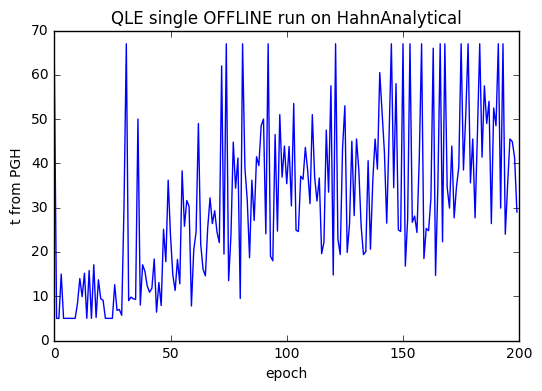

In [243]:
plt.plot(track_time)
plt.xlabel('epoch')
plt.ylabel('t from PGH')

plt.title("QLE single OFFLINE run on HahnAnalytical")

thisfig = "_tracktime___"
print(os.path.normpath(filefigname+thisfig+timestamp+".pdf"))
plt.savefig(os.path.normpath(filefigname+thisfig+timestamp+".pdf"))

plt.show()

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEsim_HahnNewAnalytical_Nparts_100_trackparams____2017-09-05_00.17.55.pdf


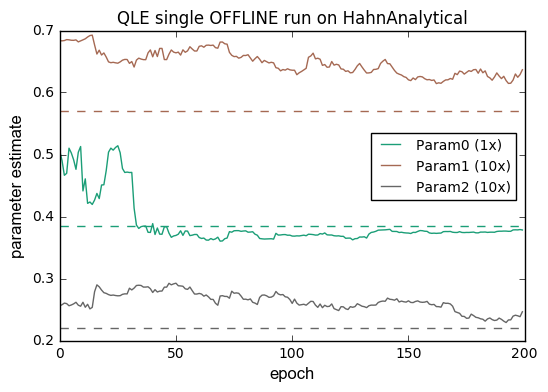

In [265]:
data_len = len(track_eval[0])
color_list = plt.cm.Dark2(np.linspace(0, 1, data_len)) 

for idx in range(data_len):
    scalefac = 1 if idx ==0 else 10
    plt.plot(scalefac*track_eval[:,idx], color=color_list[idx], label='Param'+str(idx)+" ("+str(scalefac)+"x)")
    plt.axhline(y = scalefac*true_params[0][idx], ls= '--', color=color_list[idx])

plt.title("QLE single OFFLINE run on HahnAnalytical")
plt.xlabel('epoch', **axis_font)
plt.ylabel('parameter estimate', **axis_font)
plt.legend(bbox_to_anchor=(0.67, 0.67), loc=2, borderaxespad=0., fontsize = 10)

thisfig = "_trackparams___"
print(os.path.normpath(filefigname+thisfig+timestamp+".pdf"))
plt.savefig(os.path.normpath(filefigname+thisfig+timestamp+".pdf"))

plt.show()

In [188]:
datamean = np.mean(SETTINGS.sigdata[:,1])
print("Average of data: " + str(datamean))
datavar = np.sum( (SETTINGS.sigdata[:,1] -datamean)**2  )
print("Variance of data: " + str(datavar))

Average of data: 0.675705082649
Variance of data: 7.70785925784


In [237]:
#Extract average (singular) values out of the simulations

myrange = len(track_eval)
Resid = np.empty(myrange)

start = time.clock()
for i in range(myrange):
    modpars = track_eval[i]
    simdata = HTM.OscBath_SignalModel(SETTINGS.sigdata[:,0], Nqubit =20, freqpars = track_eval[i]) #
    Resid[i] = np.sum( (simdata - SETTINGS.sigdata[:,1])**2  )
print("Time elapsed: " + str(time.clock()-start))

Time elapsed: 95.75639497254451


C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEsim_HahnNewAnalytical_Nparts_100_trackcov_Rsq____2017-09-05_00.17.55.pdf


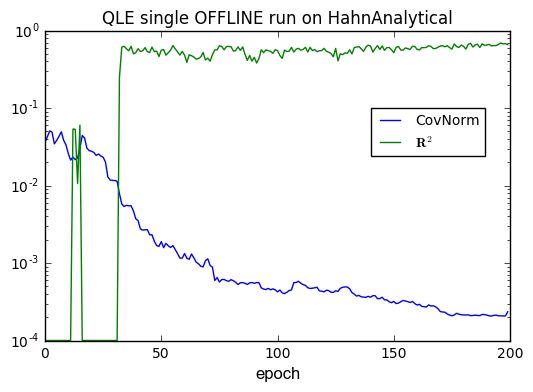

In [266]:
plt.semilogy(track_cov, label = 'CovNorm')
lowbound = 10**(np.around(np.log10(min(track_cov)),0))
plt.semilogy([max(lowbound, 1-Resido/datavar) for Resido in Resid], "g", label=r'$\mathbf{R}^2$')

# for xc in resample_events:
#     plt.axvline(x=xc, ls = '--', color = 'red')

plt.title("QLE single OFFLINE run on HahnAnalytical")
plt.xlabel('epoch', **axis_font)
plt.legend(bbox_to_anchor=(0.7, 0.75), loc=2, borderaxespad=0., fontsize = 10)

thisfig = "_trackcov_Rsq___"
filefigname = dire+"\\QLEsim_HahnNewAnalytical_Nparts_"+str(n_particles)
print(os.path.normpath(filefigname+thisfig+timestamp+".pdf"))
plt.savefig(os.path.normpath(filefigname+thisfig+timestamp+".pdf"))

plt.show()

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEsim_HahnNewAnalytical_Nparts_100_trackRsq____2017-09-05_00.17.55.pdf


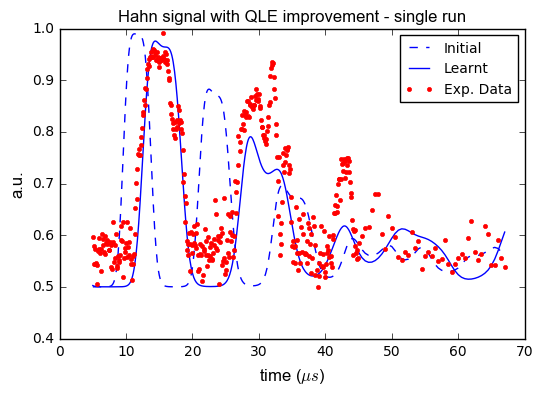

In [572]:
startdata = HTM.OscBath_SignalModel(SETTINGS.sigdata[:,0], Nqubit =20, freqpars = track_eval[0])
plt.plot(SETTINGS.sigdata[:,0], startdata, "b--", label="Initial")

simdata = HTM.OscBath_SignalModel(SETTINGS.sigdata[:,0], Nqubit =20, freqpars = track_eval[-1])
plt.plot(SETTINGS.sigdata[:,0], simdata, "b-", label="Learnt")

# simdata = HTM.OscBath_SignalModel(SETTINGS.sigdata[:,0], Nqubit =20, freqpars = true_params[0])
# plt.plot(SETTINGS.sigdata[:,0], simdata, "g-", label="Numerical")

plt.plot(SETTINGS.sigdata[:,0], SETTINGS.sigdata[:,1], "r.", label="Exp. Data")

plt.title(r'Hahn signal with QLE improvement - single run', **title_font)

plt.xlabel(r'time ($\mu s$)', **axis_font)
plt.ylabel('a.u.', **axis_font)
plt.legend(fontsize = 10)

thisfig = "_trackRsq___"
print(os.path.normpath(filefigname+thisfig+timestamp+".pdf"))
#UNCOMMENT TO SAVE PICTURE
# plt.savefig(os.path.normpath(filefigname+thisfig+timestamp+".pdf"))

plt.show()

In [554]:
from scipy import signal
tvec = np.linspace(0.,max(SETTINGS.sigdata[:,0]),400)

modeldata = HTM.OscBath_SignalModel(tvec, Nqubit =20, nrep = 150, freqpars = true_params[0]) #track_eval[-1]) #) #
peakind = signal.find_peaks_cwt(modeldata, np.arange(14, 30))

In [568]:
# peakind[0] -= 2
# peakind[1] -= 4
peakind[2] +=1
# peakind[4] -= 1
mypeaks = [tvec[peakind][0:5], modeldata[peakind][0:5]]
mypeaks

[array([  0.5037594 ,  15.28070175,  28.88220551,  42.98746867,  56.92481203]),
 array([ 0.99947635,  0.98284407,  0.88273299,  0.713975  ,  0.62108411])]

In [569]:
def func(t, offset, ratio, T2):
    return ratio * np.exp(- (2*t / T2)**3) +offset 

popt2, pcov2 = sp.optimize.curve_fit(func, mypeaks[0], mypeaks[1], bounds=(0, [1., 1., 300.]))
perr2 = np.sqrt(np.diag(pcov2))
print(r'Estimated T2 from peaks-fit: ' + str(popt2[2]) + ' +/- ' + str(perr2[2]) + ' us')

Estimated T2 from peaks-fit: 80.9986700426 +/- 1.46697594132 us


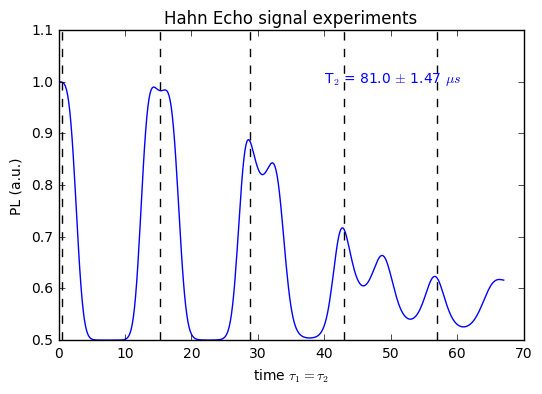

In [570]:
plt.plot(tvec, modeldata, "b-", label='model')

for xc in mypeaks[0]:
    plt.axvline(x=xc, ls = '--', color = 'black')

T2 = str(np.around(popt2[2],1)) 
T2err = str(np.around(perr2[2],2)) 
plt.text(40, 1.0, r'T$_2$ = ' + T2 + ' $\pm$ ' + T2err + ' $\mu s$' , color = 'b')

plt.title('Hahn Echo signal experiments')

plt.xlabel(r'time $\tau_1 = \tau_2$')
plt.ylabel('PL (a.u.)')

plt.show()

# Multiple tests

In [93]:
"""Same initial guess as for the QLE simulated learning"""
 
true_params = np.array([[0.385, 5.7*10**-2, 15*10**-3]])
sigmas = np.array([0.2, 2*10**-2, 6*10**-3])
scramble = np.array([-0.15, 1*10**-2, 3*10**-3])
# sigmas = np.array([0.25, 2*10**-2, 5*10**-3])
# scramble = np.array([-0.1, 1*10**-2, -2*10**-3])

In [94]:
boundaries = np.array([ [0,1], [0, 0.1], [0, 0.1]])# [0, 0.1], [0, 0.1]
np.all(true_params > boundaries[:,0], axis=1) and np.all(true_params < boundaries[:,1], axis=1)

array([ True], dtype=bool)

In [95]:
run param_sweep.py

In [102]:
invertize=False
trotterize=False
model = gsi.HahnSignalAnaSimQMD(modelparams=true_params, Nqubit_interact = 20, bound_params = boundaries,  
                     IQLE=invertize, datasource = 'offline')

n_particles = 100
n_experiments = 300

print('Initialization Ready')

Initialization Ready


In [97]:
n_trials = 500

start = time.clock()
result = list(map(lambda trial: multiple_anaqle(trial, model, true_params, scramble, sigmas, n_particles=n_particles, n_experiments=n_experiments, pgh = 0.6), range(n_trials) ))

print("\n\nElapsed time:" + str(time.clock()-start) + " secs")

Done iteration 0


C:\Program Files\Anaconda3\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 3 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 1 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Done iteration 20


C:\Program Files\Anaconda3\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 2 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Done iteration 40
Done iteration 60
Done iteration 80
Done iteration 100
Done iteration 120


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.807598814977684). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Done iteration 140
Done iteration 160
Done iteration 180
Done iteration 200


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.757539588755087). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.254498101159351). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Done iteration 220
Done iteration 240
Done iteration 260


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.105639316894731). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Done iteration 280


C:\Program Files\Anaconda3\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 5 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Done iteration 300
Done iteration 320
Done iteration 340
Done iteration 360
Done iteration 380
Done iteration 400


C:\Program Files\Anaconda3\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 4 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Done iteration 420
Done iteration 440


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.708563926990156). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Done iteration 460
Done iteration 480


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.018192486294064). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning




Elapsed time:15451.459887473247 secs


In [98]:
track_loss = np.array([result[i][0] for i in range(len(result)) ] )
track_eval = np.array([result[i][1] for i in range(len(result)) ] )
track_cov = np.array([result[i][2] for i in range(len(result)) ] )
track_stdev = np.array([result[i][3] for i in range(len(result)) ] )
track_time = np.array([result[i][4] for i in range(len(result)) ] )

In [99]:
tryme = np.mean(track_eval[:,-1], axis=0)
tryme

array([ 0.38587741,  0.06358473,  0.01901431])

In [80]:
track_eval[3,-1]

array([ 0.39042735,  0.05829022,  0.01893303])

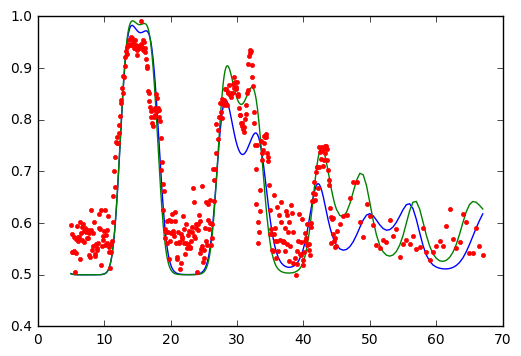

In [100]:
tryme = track_eval[3,-1]
simdata = HTM.OscBath_SignalModel(SETTINGS.sigdata[:,0], Nqubit =20, nrep =25, freqpars = tryme)
plt.plot(SETTINGS.sigdata[:,0], simdata, "b-", label="Learnt")

bestdata = HTM.OscBath_SignalModel(SETTINGS.sigdata[:,0], Nqubit =20, nrep =25, freqpars = true_params[0])
plt.plot(SETTINGS.sigdata[:,0], bestdata, "g-", label="NM optimal")

plt.plot(SETTINGS.sigdata[:,0], SETTINGS.sigdata[:,1], "r.", label="Exp. Data")
plt.show()

In [65]:
track_loss[0:18,-1]

array([  3.31890948e-03,   1.03913387e-04,   3.47402176e-05,
         3.48573891e-05,   6.05020082e-04,   1.22004007e-04,
         1.14108238e-04,   2.81794447e-04,   1.90021040e-04,
         1.50151515e-04,   7.08623976e-05,   5.04705221e-04,
         8.86011873e-04,   5.01021906e-04,   1.38953365e-04,
         5.55388823e-05,   1.12437157e-04,   8.84206955e-05])

In [113]:
badlist = []
for i in range(len(track_loss)):
    if (track_loss[i, -1] > 10**-3):
        badlist.append(i)
len(badlist)

67

## Data export - multiple tests

In [103]:
allfilenames = dire+"\\GenSim_NEWanalytical_QLE_simTEST_Nruns_"+str(n_trials)+"_Nparts_"+str(n_particles)+"_Nparams_"+str(len(true_params[0]))

labelize = '_IQLE' if invertize == True else '_QLE'

In [104]:
timestamp = mytimestamp()

thisfile = "_alldata___"
thisfile = allfilenames+thisfile+timestamp+".dat"
print('Data saving in\n'+thisfile)

Data saving in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\GenSim_NEWanalytical_QLE_simTEST_Nruns_500_Nparts_100_Nparams_3_alldata____2017-09-10_17.46.38.dat


In [231]:
import pickle as pickle
with open(thisfile, "wb") as f:
    pickle.dump(result, f)

In [221]:
# Reload if OLDDATA are required
PIK = dire+"\\GenSim_NEWanalytical_QLE_simTEST_Nruns_500_Nparts_100_Nparams_3_alldata____2017-09-04_10.40.27.dat"

with open(PIK, "rb") as f:
    dataold = pickle.load(f)
    
#prepare data
track_loss =  dataold[0]
track_eval = dataold[1]
track_cov =  dataold[2]
track_stdev =  dataold[3]
track_time =  dataold[4]


## Plots - multiple tests (to be repeated)

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\GenSim_NEWanalytical_QLE_simTEST_Nruns_500_Nparts_100_Nparams_3_trackloss____2017-09-10_17.46.38.pdf


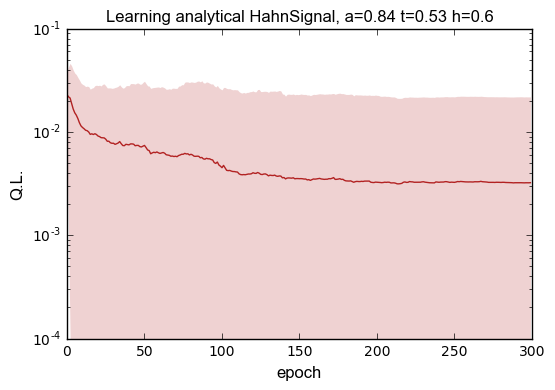

In [105]:
meanQL = np.mean(track_loss, axis = 0)
#errQL = np.mean(track_cov, axis = 0) 
errQL = np.std(track_loss, axis = 0)

steps = range(len(meanQL))

plt.semilogy(meanQL, color='firebrick')
plt.fill_between(steps, meanQL+errQL, [max(meanQL[i]-errQL[i], 10**-4) for i in steps],
    alpha=0.2, linewidth=0, facecolor='firebrick', antialiased=True)

plt.title('Learning analytical HahnSignal, a=0.84 t=0.53 h=0.6', **title_font )
plt.xlabel('epoch', **axis_font)
plt.ylabel('Q.L.', **axis_font)

thisfig = "_trackloss___"
filefigname = os.path.normpath(allfilenames+thisfig+timestamp+".pdf")
print(filefigname)
#plt.savefig(filefigname)

plt.show()

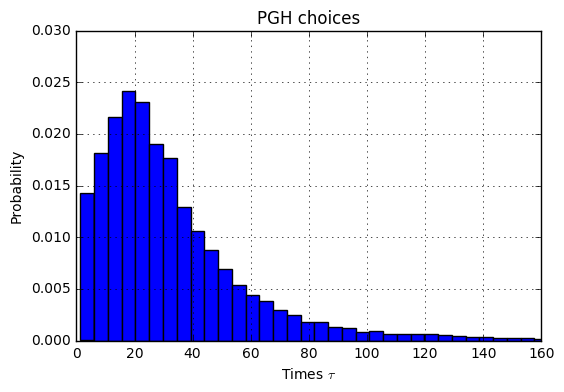

In [1474]:
# the histogram of the data
n, bins, patches = plt.hist(track_time.ravel(), 300, normed=1)

plt.xlabel(r'Times $\tau$')
plt.ylabel('Probability')
plt.title('PGH choices')
plt.axis([0, 160, 0, 0.03])
plt.grid(True)
plt.show()

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\GenSim_analytical_QLE_simTEST_Nruns_500_Nparts_100_Nparams_3_trackparams____2017-08-30_12.50.10.pdf


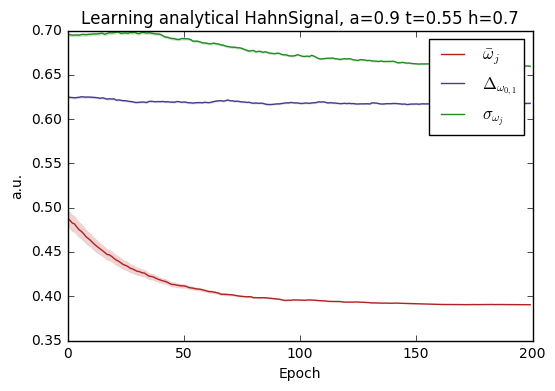

In [123]:
meaneval = np.mean(track_eval, axis = 0)
meanstdev = np.mean(track_stdev, axis = 0)

enhance1 = 50
enhance2 = 20

plt.plot(meaneval[:,0], 'k', label=r'$\bar{\omega}_j$', color='firebrick')
plt.fill_between(steps, meaneval[:,0]-meanstdev[:,0], meaneval[:,0]+meanstdev[:,0],
    alpha=0.2, linewidth=0, facecolor='firebrick', antialiased=True)

plt.plot(enhance1*meaneval[:,1], label=r'$\Delta_{\omega_{0,1}}$', color='darkslateblue')
plt.fill_between(steps, enhance1*(meaneval[:,1]-meanstdev[:,1]), enhance1*(meaneval[:,1]+meanstdev[:,1]),
    alpha=0.2, linewidth=0, facecolor='darkslateblue', antialiased=True)

plt.plot(enhance2*meaneval[:,2], label=r'$\sigma_{\omega_j}$', color='forestgreen')
plt.fill_between(steps, enhance2*(meaneval[:,2]-meanstdev[:,2]),enhance2*(meaneval[:,2]+meanstdev[:,2]),
    alpha=0.2, linewidth=0, facecolor='forestgreen', antialiased=True)

plt.title('Learning analytical HahnSignal, a=0.9 t=0.55 h=0.7' )
plt.xlabel('Epoch')
plt.ylabel('a.u.')
plt.legend()

thisfig = "_trackparams___"
filefigname = allfilenames+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)

#UNCOMMENT TO SAVE PICTURE
print(filefigname)
plt.savefig(filefigname)

plt.show()

# Compare the average obtained parameters against the experimental dynamics

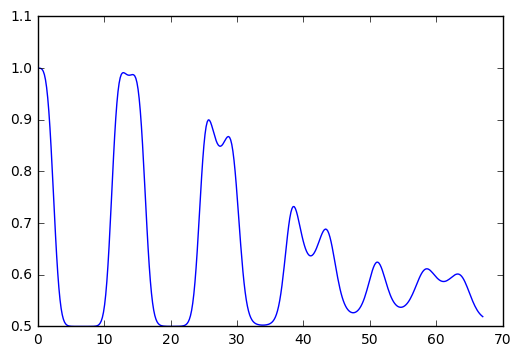

In [620]:
modeldata = HTM.OscBath_SignalModel(tvec, Nqubit =20, nrep = 150, freqpars = np.mean(track_eval[:, -1], axis =0) )
plt.plot(tvec, modeldata, "b-", label='model')

plt.show()

In [435]:
# Extract experimental data to plot

directory = os.path.join("..","..","..","Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02")
moredata =  ImportAllFolder_Hahnpeak(directory, clean_duplicates = True)  

myrange = range(0, min(moredata.shape[0],500)) 

# the 1000 factor converts ns to us
moredata = [ [moredata[i,0]/1000 , moredata[i,1]] for i in myrange]
moredata = np.array(moredata)

offset = 0.18
moredata[:,0] = moredata[:,0]-offset

In [436]:
# Select a specific run of the simulations if needed
runID = 5

In [437]:
#Extract average (singular) values out of the simulations

testFinEstimParams = np.mean(track_eval[:][-1], axis=0)
#testFinEstimParams = track_eval[runID][-1]
myHfA = testFinEstimParams[0:3]
print(myHfA)
myBathfreq = testFinEstimParams[3:6]
print(myBathfreq)

[-2.85253252 -2.76159646 -2.12561744]
[ 0.65648023  0.43504202  0.54913253]


myHfA = [-2.89211754, -2.70041014, -2.01418793]
myBathfreq = [ 1,2,3]

Picture saved in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\CompareData_PostProcModel_noDeco_2017-08-23_13.12.42.pdf


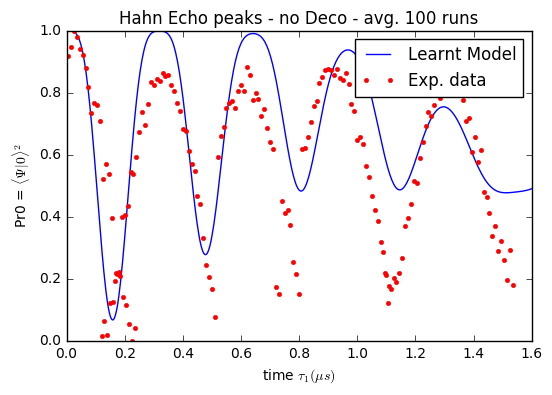

In [442]:
tvec = np.linspace(0.,1.6,500)

simdata = HTM.Q2_HF_Precession(tvec, HfA = myHfA, Bathfreq = myBathfreq)
plt.plot(tvec, simdata, "b-")

expdata = rescaledatatofullrange(moredata[:,1])
plt.plot(moredata[:,0], expdata, "r.")
plt.xlim([0,1.6])

plt.legend(('Learnt Model', 'Exp. data'))

plt.title(r'Hahn Echo peaks - no Deco - avg. 100 runs')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $')

filefigname = dire+"\CompareData_PostProcModel_noDeco"+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)
plt.savefig(filefigname)
print('Picture saved in\n'+filefigname)

plt.show()